Rolling Window RSQ: 0.962


C:\Users\pauln\AppData\Local\Temp/ipykernel_24012/2965026126.py:187: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  models_rolling_window = pd.Series(index=recalc_dates)
C:\Users\pauln\AppData\Local\Temp/ipykernel_24012/2965026126.py:205: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predictions_rolling_window = pd.Series(index=features.index)


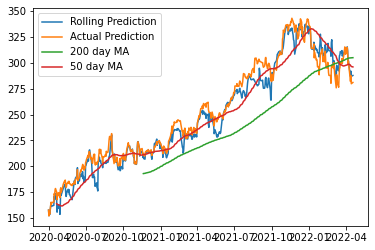

In [1]:
import time
import talib
import calendar
import datetime
import requests
from config import client_id
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.base import clone
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

#Takes date entered and returns the epoch time
def date(year, month, day, hour, minute):
    from datetime import date
    import time

    z = int(time.mktime(time.strptime(f'{year}-{month}-{day} {hour}:{minute}', "%Y-%m-%d %H:%M")))
    
    return z

#For some odd reason there needs to be 3 more 0's for the TDAmeritrade api to properly collect this information

#Jan 25th, 2020
start_date = date(2020, 2, 7, 9, 30)
#Gets today's date as an epoch
end_date = calendar.timegm(time.gmtime())

def get_priceHistory(start_date, end_date, symbol):
    
    #Multiply epoch date to add 3 extra zero's
    start_date, end_date = start_date*1000, end_date*1000
    
    payload = {
    'apikey':client_id,
    }


    #endpoint = f'https://api.tdameritrade.com/v1/marketdata/{symbol.upper()}/pricehistory?\
    #periodType=month&frequencyType=daily&needExtendedHoursData=true&frequency=1&startDate={start_Date}&endDate={end_Date}'
    
    endpoint = f'https://api.tdameritrade.com/v1/marketdata/{symbol.upper()}/pricehistory?periodType=month\
    &frequencyType=daily&startDate={start_date}&endDate={end_date}'

    content = requests.get(url = endpoint, params = payload)

    data = content.json()
    
    #The columns on my dataframe
    my_columns = ['datetime', 'open','high', 'low','close','volume']

    dataframe = pd.DataFrame(columns = my_columns)

    #Creating a dictionary of lists
    fields = {key: [] for key in my_columns}

    #Iterates through the keys in the fields dictionary
    #Date is arranged as (Year-Month-Day)
    for key in fields:
        datetime_key = key
        if datetime_key == 'datetime':
            for i in range(0, len(data['candles'])):
                fields[f'{key}'].append(data["candles"][i][f'{key}'])
                epochtime = fields['datetime'][i]
                time_formatted = time.strftime('%Y-%m-%d %H:%M', time.localtime(epochtime/1000))
                fields[f'{key}'][i] = time_formatted 
        else:
            for i in range(0, len(data['candles'])):
                fields[f'{key}'].append(data["candles"][i][f'{key}'])
                
    #Appends to the dataframe the dictionary of lists('fields')
    dataframe = pd.DataFrame(fields)
    
    #Adds the ticker symbol at front of the dataframe
    dataframe.insert(loc=0, column='Ticker', value=f'{symbol.upper()}')
    
    #Changes date into datetime object
    dataframe['datetime'] =  pd.to_datetime(dataframe['datetime'], infer_datetime_format=True)
    
    return dataframe

df_msft = get_priceHistory(start_date, end_date, 'MSFT')
df_tgtx = get_priceHistory(start_date, end_date, 'TGTX')

#Making a 'features' dataframe which will contain the features of the stocks in question
features = pd.DataFrame(index=df_msft.index).sort_index()

#For getting the n_day regression coefficient


def linear_regression(x, y):
    """
    performs linear regression given x and y. outputs regression coefficient
    """
    #fit linear regression
    lr = LinearRegression()
    lr.fit(x, y)
    
    return lr.coef_[0][0]

#Takes n days, dataframe, and features dataframe
def n_day_regression(n, df, features_df):
    """
    n day regression.
    """
    #variable
    _varname_ = f'{n}_reg'
    features_df[_varname_] = np.nan

    idxs = np.arange(0, len(df))
    for idx in idxs:
        if idx > n:
            
            y = df['close'][idx - n: idx].to_numpy()
            x = np.arange(0, n)
            #reshape
            y = y.reshape(y.shape[0], 1)
            x = x.reshape(x.shape[0], 1)
            #calculate regression coefficient 
            coef = linear_regression(x, y)
            features_df.loc[idx, _varname_] = coef #add the new value
            
    return features_df

#Trying the scale the coefficients
scaler = MinMaxScaler()


#Numbers to scale using min-max
# numbers close to 1 indicate a the stock closed near the HIGH of the day, 
# while lower numbers indicate the closing near the LOW of the day

# change from open today from open yesterday
#features['pct_change(not_in_%)'] = (df_msft.open/df_msft.open.shift(1)-1).values

# log of daily volume
#features['Log_volume'] = df_msft.volume.apply(np.log) 

n_day_regression(5, df_msft, features)
n_day_regression(10, df_msft, features)
n_day_regression(30, df_msft, features)

features_scaled = scaler.fit_transform(features)
features = pd.DataFrame(features_scaled, columns = features.columns)

#Features not to use min_max with
#Kind of standardizes the information on tick data, but maybe peeks into the future
#features['Norm_prices'] = (df_msft.close-df_msft.low)/(df_msft.high - df_msft.low)
#features['MA_50'] = df_msft.close.rolling(50).mean()

#Maybe find some way to better standardize the price instead of only using the closing price on the day
#features['Price_Rate_Of_Change'] = df_msft['close'].transform(lambda x: x.pct_change(periods = 9))

#features1['Move_avg50'] = talib.MA(df_msft['close'], timeperiod=50, matype=0)
featuresMA = pd.DataFrame(talib.MA(df_msft['close'], timeperiod=50, matype=0), columns = ['Move_avg50'])
featuresMA['Move_avg200'] = talib.MA(df_msft['close'], timeperiod=200, matype=0)

#features['SMA_25'] = talib.SMA(df_msft['close'], timeperiod=25)
#features['EMA_25'] = talib.EMA(df_msft['close'], timeperiod=50)
features['RSI'] = talib.RSI(df_msft['close'], timeperiod=14)

features = features.dropna()

#Reindexing the msft dataframe to reflect the change that dropped features now have
df_msft_reindexed = df_msft.reindex(features.index)
featuresMA = featuresMA.reindex(features.index)

#Reindexes the df_msft_reindexed to drop other rows and make datetime the new index
df_msft_setIndex = df_msft_reindexed.set_index('datetime')

features = features.set_index(df_msft_reindexed['datetime'])
featuresMA = featuresMA.set_index(df_msft_reindexed['datetime'])

recalc_dates = df_msft_setIndex.resample('M', level='datetime' ).mean().index.values[:-1]
first_day_month = df_msft_setIndex.resample('MS', level='datetime').mean().index.values[:-1]

features = features.set_index(df_msft_reindexed['datetime'])
recalc_dates = df_msft_setIndex.resample('M', level='datetime' ).mean().index.values[:-1]
first_day_month = df_msft_setIndex.resample('MS', level='datetime').mean().index.values[:-1]

#Rolling Window    
models_rolling_window = pd.Series(index=recalc_dates)
for first_day, date in zip(first_day_month, recalc_dates):
    
    X_train = features.loc[first_day:(date + pd.Timedelta(1, 'day'))]
    y_train = df_msft_setIndex.loc[first_day:(date + pd.Timedelta(1, 'day')), 'close']
    
    df_msft_setIndex.loc[first_day:(date + pd.Timedelta(1, 'day')), 'close']
    
    model = LinearRegression()
    model.fit(X_train,y_train)
    models_rolling_window.loc[date] = model
    
begin_dates = models_rolling_window.index
end_dates = models_rolling_window.index[1:].append(pd.to_datetime(['2099-12-31']))

#Predicting Rolling window

#NEED TO CHANGE THIS AS I AM PREDICTING WHAT I HAVE ALREADY TRAINED!
predictions_rolling_window = pd.Series(index=features.index)
for i,model in enumerate(models_rolling_window): #loop thru each model object in collection
    X = features.loc[begin_dates[i]:end_dates[i]]
    p = pd.Series(model.predict(X),index=X.index)
    predictions_rolling_window.loc[X.index] = p

#Dropping rows from the windows
predictions_rolling_window = pd.DataFrame(predictions_rolling_window.dropna())

#Finding the intersection of the common indexes
idx = df_msft_setIndex.index.intersection(predictions_rolling_window.index)

#Making a new dataframe containing only the intersection
df_msft_setIndex = df_msft_setIndex.loc[idx]

rsq_rolling = r2_score(y_true = df_msft_setIndex.loc[: ,'close']\
                       ,y_pred = predictions_rolling_window)

print("Rolling Window RSQ: {}".format(round(rsq_rolling,3)))

plt.plot(predictions_rolling_window, label = 'Rolling Prediction')
plt.plot(df_msft_setIndex['close'], label = 'Actual Prediction')
plt.plot(featuresMA['Move_avg200'], label = '200 day MA')
plt.plot(featuresMA['Move_avg50'], label = '50 day MA')
plt.legend()
plt.show()